## [Dacon]태양광 발전량 예측 AI 경진대회
## 우럭이 안우럭
## 2021년 1월 31일 

## 1. 라이브러리 및 데이터
## Library & Data

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
%matplotlib inline
import math
import itertools
import warnings
warnings.filterwarnings(action='ignore')
from tqdm import tnrange, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

In [67]:
train = pd.read_csv('../data/train/train.csv')

submission = pd.read_csv('../data/sample_submission.csv')
submission.set_index('id',inplace=True)

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [17]:
train.isnull().sum()

Day       0
Hour      0
Minute    0
DHI       0
DNI       0
WS        0
RH        0
T         0
TARGET    0
dtype: int64

In [18]:
df.describe()

,DHI,DNI,WS,RH,T,TARGET,GHI,DP
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630,170.937627,-0.286467
std,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955,213.324929,7.702938
min,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000,0.000000,-26.075522
25%,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000,0.000000,-5.732826
50%,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000,0.000000,-0.662582
75%,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890,387.580939,5.790448
max,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939,700.964276,17.220399


## 3. 탐색적 자료분석
## Exploratory Data Analysis


<Figure size 1152x1080 with 0 Axes>

[Text(0, 0.5, 'Index'), Text(0.5, 0, 'Value'), Text(0.5, 1.0, 'Parmeter')]

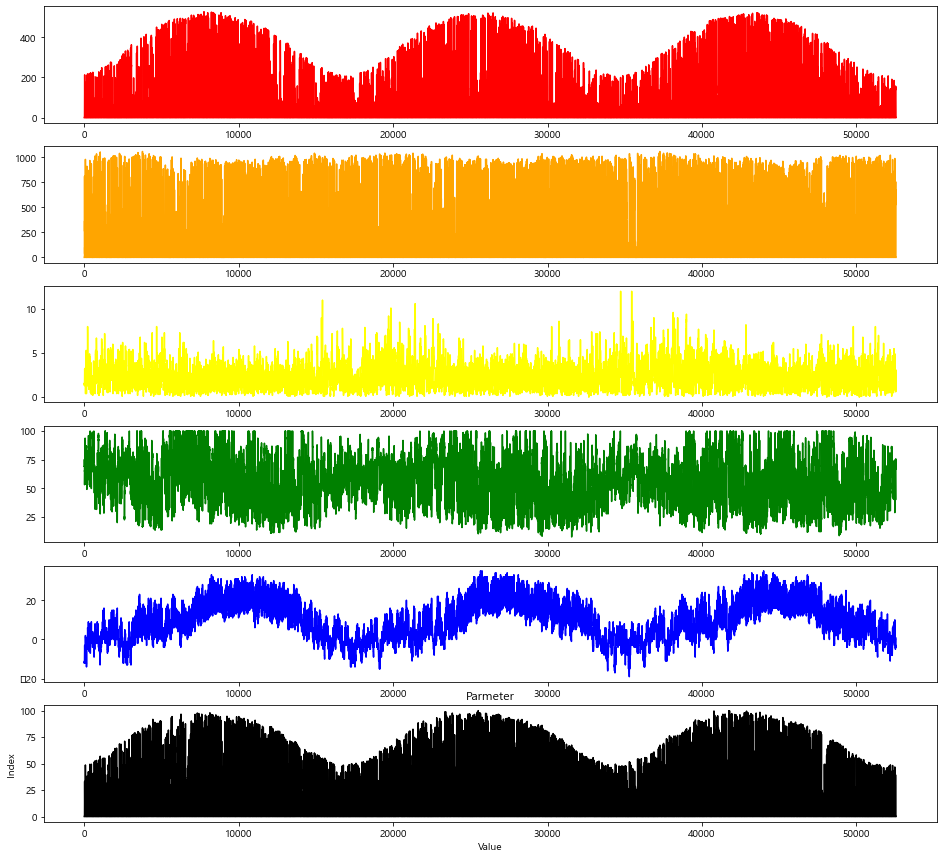

In [63]:
parameter_list = ["DHI", "DNI", "WS", "RH", "T", "TARGET"]
color_list = ["red", "orange", "yellow", "green", "blue", "black"]

plt.figure(figsize=(16,15))
for i in range(6):
    plt.subplot(6, 1, i+1)
    plt.plot(train.index, train[parameter_list[i]], color=color_list[i])

plt.gca().set(title="Parmeter", xlabel="Value", ylabel="Index")
plt.show()

<Figure size 1440x1080 with 0 Axes>

Text(0.5, 1.0, 'Summer')

(0.0, 100.0)

Text(0.5, 1.0, 'Winter')

(0.0, 100.0)

Text(0.5, 1.0, 'Summer')

(0.0, 100.0)

Text(0.5, 1.0, 'Winter')

(0.0, 100.0)

Text(0.5, 1.0, 'Summer')

(0.0, 100.0)

Text(0.5, 1.0, 'Winter')

(0.0, 100.0)

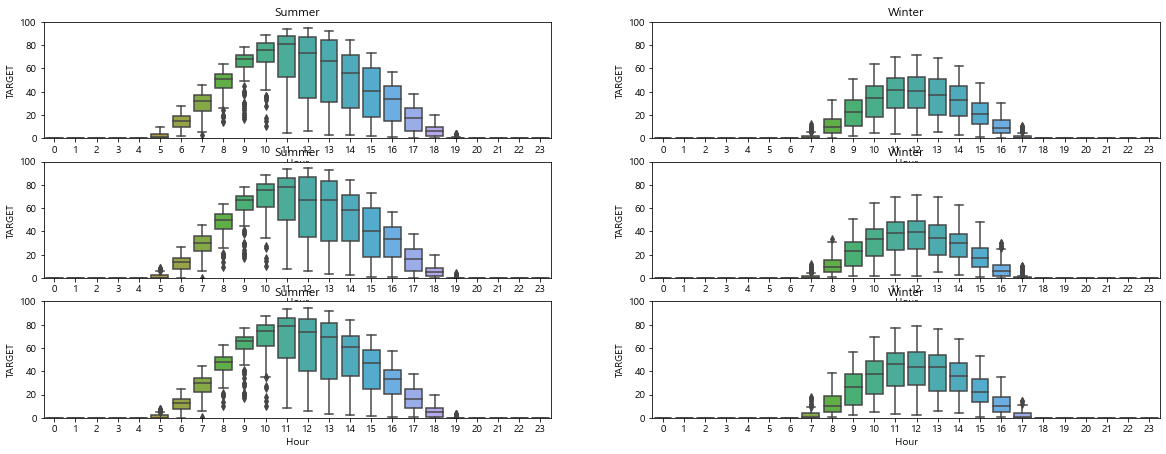

In [73]:
# 여름(6, 7, 8월) / 겨울(1, 2, 12월)
winter_month = []
summer_month = []
for i in range(3):
    summer_month.append(train.iloc[i*365 + 180*48 : i*365 + 240*48 ])
    winter_df_1 = train.iloc[i*365 : i*365 + 60 * 48]
    winter_df_2 = train.iloc[i*365 + 335*48 : i*365 + 365*48 ]
    winter_df = pd.concat([winter_df_1, winter_df_2])
    winter_month.append(train.iloc[i*365 : i*365 + 60 * 48])
    winter_month.append(winter_df)

# 시각화 코드
plt.figure(figsize=(20,15))
subplot_index = 0
for i in range(1, 4):
    plt.subplot(6,2, i*2-1)
    sns.boxplot(x="Hour", y="TARGET", data=summer_month[i-1])
    plt.title("Summer")
    plt.ylim(0, 100)
    plt.subplot(6, 2, i*2)
    sns.boxplot(x="Hour", y="TARGET", data=winter_month[i-1])
    plt.title("Winter")
    plt.ylim(0, 100)
plt.show()

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [5]:
# 최적의 전천일사량을 위한 각도 search
corrList = []
corr = lambda p : p['TARGET'].corr(p['GHI'])

def makeCorrList(df):
    result = corr(df)
    corrList.append(result)

for i in range(0,90):
    df['GHI'] = df['DNI']*math.cos(math.pi/180*i)+df['DHI']
    makeCorrList(df)

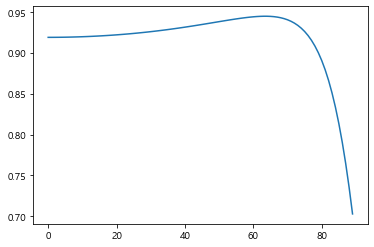

In [6]:
x = np.arange(0,90)
plt.plot(x,corrList)
plt.show()

In [7]:
print(corrList.index(max(corrList)), max(corrList))

63 0.9451229383187152


In [19]:
# 이슬점온도 Column 추가
def makeDewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [22]:
# 전천일사량 컬럼 추가
train['GHI'] = train['DNI']*math.cos(math.pi/180*63)+train['DHI']
train['DP'] = 0
for i in range(len(train)):
    train.loc[i, ["DP"]] = makeDewpoint(float(train.loc[i, ["T"]]), train.loc[i , ["RH"]])

In [23]:
train = train.drop(['Day', 'Hour', 'Minute'], axis = 1)
init_x_train = train.drop(['TARGET'], axis = 1)
init_y_train = train['TARGET']

<Figure size 720x576 with 0 Axes>

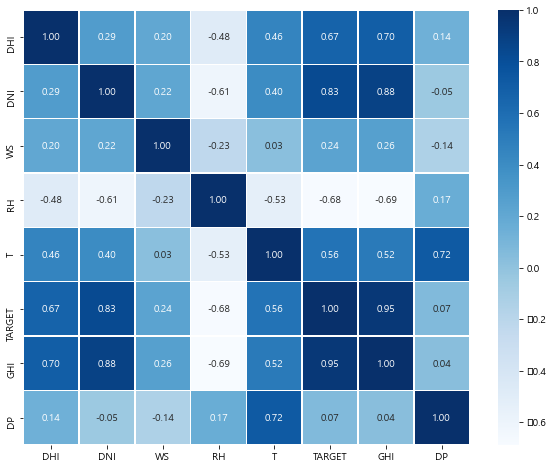

In [24]:
# feature간 상관계수
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), annot=True,
fmt='.2f', linewidths=.5, cmap='Blues')

In [25]:
def random_forest(X,y):
    model = RandomForestRegressor(n_estimators=100, max_features=0.25)
    model.fit(X,y)
    RSS = mean_squared_error(y,model.predict(X)) * len(y)
    R_squared = model.score(X,y)
    return RSS, R_squared

In [27]:
# randomforest feature optimization
m = len(init_y_train)
k = 7
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#모든 조합에 대한 성능 테스트(RSS, R_Squared)
for k in tnrange(1,len(init_x_train.columns) + 1):
    for combo in itertools.combinations(init_x_train.columns,k):
        tmp_result = random_forest(init_x_train[list(combo)],init_y_train)  
        RSS_list.append(tmp_result[0])              
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#결과
eda = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

In [28]:
# randomforest feature optimization
eda['min_RSS'] = eda.groupby('numb_features')['RSS'].transform(min)
eda['max_R_squared'] = eda.groupby('numb_features')['R_squared'].transform(max)
eda

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,9.666090e+06,0.722851,"(DHI,)",289227.183925,0.991707
1,1,7.626456e+06,0.781332,"(DNI,)",289227.183925,0.991707
2,1,3.247093e+07,0.068983,"(WS,)",289227.183925,0.991707
3,1,1.261479e+07,0.638305,"(RH,)",289227.183925,0.991707
4,1,2.144694e+07,0.385067,"(T,)",289227.183925,0.991707
...,...,...,...,...,...,...
122,6,1.324795e+04,0.999620,"(DHI, DNI, WS, T, GHI, DP)",13247.947793,0.999620
123,6,1.388266e+04,0.999602,"(DHI, DNI, RH, T, GHI, DP)",13247.947793,0.999620
124,6,3.571204e+04,0.998976,"(DHI, WS, RH, T, GHI, DP)",13247.947793,0.999620
125,6,5.212961e+04,0.998505,"(DNI, WS, RH, T, GHI, DP)",13247.947793,0.999620


In [29]:
eda_min = eda[eda.groupby('numb_features')['RSS'].transform(min) == eda['RSS']]
eda_min

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
5,1,289227.183925,0.991707,"(GHI,)",289227.183925,0.991707
16,2,115599.194600,0.996686,"(DNI, GHI)",115599.194600,0.996686
40,3,14660.843058,0.999580,"(DHI, T, GHI)",14660.843058,0.999580
70,4,13766.120156,0.999605,"(DHI, DNI, T, GHI)",13766.120156,0.999605
107,5,10511.337148,0.999699,"(DHI, DNI, T, GHI, DP)",10511.337148,0.999699
122,6,13247.947793,0.999620,"(DHI, DNI, WS, T, GHI, DP)",13247.947793,0.999620
126,7,21112.106737,0.999395,"(DHI, DNI, WS, RH, T, GHI, DP)",21112.106737,0.999395


In [57]:
day = 2

past_history = 48 * day
future_target = 48 * 2

In [30]:
# real model feature selection, data transformation
def preprocess(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels
x_col = ['DHI', 'DNI', 'T', 'TARGET','GHI', 'DP']
y_col = ['TARGET']
dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

### train set
train_data, train_label = preprocess(dataset, label, 0, None, past_history,future_target, 1)
train_data = np.nan_to_num(train_data)

In [31]:
### test set
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'../data/test/{i}.csv')
    tmp['GHI'] = tmp['DNI']*math.cos(math.pi/180*63)+tmp['DHI']
    tmp['DP'] = 0
    for i in range(len(tmp)):
        tmp.loc[i, ["DP"]] = makeDewpoint(float(tmp.loc[i, ["T"]]), tmp.loc[i , ["RH"]])    
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

In [32]:
print(train_data.shape)
print(train_label.shape)

(1091, 576)
(1091, 96)


In [33]:
# Hyperparameter optimization
features = []
x_features = np.arange(1,21)
N_ESTIMATORS = 500

for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=i, random_state=0,
                                    max_depth = 5,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    features.append(rf.score(train_data, train_label))

depth = []
x_depth = np.arange(1,21)
N_ESTIMATORS = 500
for i in range(1,21):
    rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=5, random_state=0,
                                    max_depth = i,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    depth.append(rf.score(train_data, train_label))
    
estimator = []
x_estimator = np.arange(1000,2100,100)
for i in range(1000,2100,100):
    rf = RandomForestRegressor(n_estimators=i,
                                    max_features=5, random_state=0,
                                    max_depth = 5,
                                    verbose=True,
                                    n_jobs=-1)
    rf.fit(train_data, train_label)
    estimator.append(rf.score(train_data, train_label))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.7s finished


RandomForestRegressor(max_depth=5, max_features=1, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


RandomForestRegressor(max_depth=5, max_features=2, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


RandomForestRegressor(max_depth=5, max_features=3, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished


RandomForestRegressor(max_depth=5, max_features=4, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(max_depth=5, max_features=6, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished


RandomForestRegressor(max_depth=5, max_features=7, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(max_depth=5, max_features=8, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(max_depth=5, max_features=9, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


RandomForestRegressor(max_depth=5, max_features=10, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.0s finished


RandomForestRegressor(max_depth=5, max_features=11, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestRegressor(max_depth=5, max_features=12, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.3s finished


RandomForestRegressor(max_depth=5, max_features=13, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


RandomForestRegressor(max_depth=5, max_features=14, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished


RandomForestRegressor(max_depth=5, max_features=15, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished


RandomForestRegressor(max_depth=5, max_features=16, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.8s finished


RandomForestRegressor(max_depth=5, max_features=17, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.1s finished


RandomForestRegressor(max_depth=5, max_features=18, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.0s finished


RandomForestRegressor(max_depth=5, max_features=19, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.5s finished


RandomForestRegressor(max_depth=5, max_features=20, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomForestRegressor(max_depth=1, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


RandomForestRegressor(max_depth=2, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


RandomForestRegressor(max_depth=3, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.1s finished


RandomForestRegressor(max_depth=4, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


RandomForestRegressor(max_depth=6, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished


RandomForestRegressor(max_depth=7, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestRegressor(max_depth=8, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


RandomForestRegressor(max_depth=9, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.7s finished


RandomForestRegressor(max_depth=10, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.0s finished


RandomForestRegressor(max_depth=11, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.2s finished


RandomForestRegressor(max_depth=12, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.4s finished


RandomForestRegressor(max_depth=13, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.7s finished


RandomForestRegressor(max_depth=14, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.6s finished


RandomForestRegressor(max_depth=15, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.9s finished


RandomForestRegressor(max_depth=16, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.0s finished


RandomForestRegressor(max_depth=17, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.0s finished


RandomForestRegressor(max_depth=18, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.3s finished


RandomForestRegressor(max_depth=19, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.1s finished


RandomForestRegressor(max_depth=20, max_features=5, n_estimators=500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1000, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    3.3s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1100, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1100 out of 1100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    3.9s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1200, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    3.7s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1300, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1300 out of 1300 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:    4.0s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1400, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1400 out of 1400 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    4.5s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1500, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    5.3s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1600, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1600 out of 1600 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1700 out of 1700 | elapsed:    5.3s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1700, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1700 out of 1700 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    6.1s finished


RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1800, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1800 out of 1800 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Do

RandomForestRegressor(max_depth=5, max_features=5, n_estimators=1900, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1900 out of 1900 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Do

RandomForestRegressor(max_depth=5, max_features=5, n_estimators=2000, n_jobs=-1,
                      random_state=0, verbose=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.8s finished


Text(0.5, 0, 'features')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'depth')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'estimator')

Text(0, 0.5, 'accuracy')

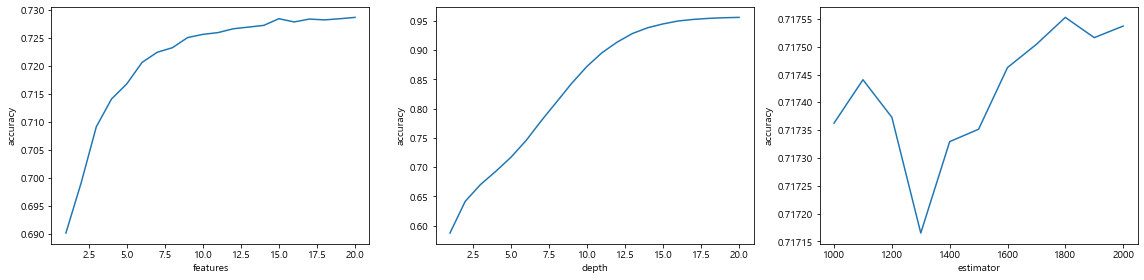

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

x = np.linspace(0, 1, 100)

axes[0].plot(x_features, features)
axes[0].set_xlabel("features")
axes[0].set_ylabel("accuracy")
axes[1].plot(x_depth, depth)
axes[1].set_xlabel("depth")
axes[1].set_ylabel("accuracy")
axes[2].plot(x_estimator, estimator)
axes[2].set_xlabel("estimator")
axes[2].set_ylabel("accuracy")

fig.tight_layout()

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [35]:
# random forest real modeling
from sklearn.ensemble import RandomForestRegressor
N_ESTIMATORS = 1800
features = 20
depth = 20

rf = RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=features, random_state=0,
                                    max_depth = depth,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)
print("Clear")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   35.5s finished


RandomForestRegressor(max_depth=20, max_features=20, n_estimators=1800,
                      n_jobs=-1, random_state=0, verbose=True)

Clear


## 6. 결과 및 결언
## Conclusion & Discussion

In [36]:
# prediction
rf_preds = []
for estimator in rf.estimators_:
    result = estimator.predict(test).astype(np.float64)
    rf_preds.append(result)
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    
    submission.iloc[:, i] = np.ravel(y_pred)

In [37]:
submission.to_csv(f'final.csv')